# 0. Gameplan

Let's make a pandas dataframe with columns.

Metadata
1. path
2. fps
2. position
3. object
5. t_duration
4. t_start
5. t_end
6. f_start
7. f_end
8. n_lasers

Now the actual data should have the columns:
1. time (30_000)
2. shifts_raw (100,30_000,2)
3. shifts (100,30_000,2)
4. fft freq (100,11_000,2)
5. fft val (100,11_000,2)
9. fft val phase-synced (100,11_000,2)
6. mode fft freq (100,5,2)
8. mode time (100,5,2)
7. mode fft val (100,5,2)
10. mode fft val phase-synced (100,5,2)
 
Visualizations:
1. x,y shifts over all lasers over time
2. FFT magnitude averaged over lasers, time
3. modes
    1. FFT magnitude
    2. x,y shifts
    3. surface reconstruction
3. Dimension Reduction:
    1. PCA 2D,3D + cumulative PCA variance + PCA pairwise distance
    2. Diffusion Map 2D,3D + cumulative Diffusion Map variance + Diffusion Map pairwise distance

compare 2D PCA of
1. (shifts, shifts_raw)
2. (fft val magnitude, fft val angle, fft val magnitude+angle)
3. (all frequencies, just mode frequencies)
4. (not phase-synced, phase-synced)
5. (duplicates, no duplicates)

The ideal results is that the best representation comes from doing PCA on:
1. phase-synced
2. modes
3. with magnitude+amplitude
4. and duplicates

I think I should use polars, hf_dataset?

Some metrics!
1. Measure the variance from 3 PCA
2. Measure the number of PCAs needed to reach 90% variance
3. Measure for what number of PCA the duplicates are closest to each other

Plot the number of modes VS the above metrics!

# 1. Setup

In [1]:
# reload all modules every time before executing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
import sys, types

import numpy as np

In [3]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    print('adding `recover_core_lib` to sys')
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

adding `recover_core_lib` to sys


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# this automatically displays all plots, even if we don't have plt.show()
# this also makes all plots interactive
%matplotlib widget

# 2. Load Data

In [6]:
from collections import defaultdict

In [7]:
BASE_DIR = Path('../data/experiment_01/')
exp_dirs = sorted([d for d in BASE_DIR.iterdir() if d.is_dir()])
print(f'Found {len(exp_dirs)} experiment directories')
exp_dirs

Found 8 experiment directories


[PosixPath('../data/experiment_01/cube_pos1_29_12_Time_19_16_40'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_03_39'),
 PosixPath('../data/experiment_01/cube_pos2_29_12_Time_19_13_50'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_27_21'),
 PosixPath('../data/experiment_01/cube_pos3_29_12_Time_19_29_43'),
 PosixPath('../data/experiment_01/cube_pos4_29_12_Time_19_24_21'),
 PosixPath('../data/experiment_01/cube_pos5_29_12_Time_19_22_12'),
 PosixPath('../data/experiment_01/cube_pos6_29_12_Time_19_20_07')]

In [8]:
def load_data(exp_dirs) -> dict:
    """Load recovery and metadata from an experiment directory."""

    duplicate_idx_map = defaultdict(int)
    data = {}

    for exp_dir in exp_dirs:
        recovery = np.load(exp_dir / 'RECOVERY.npz', allow_pickle=True)
        fs = recovery['run_opt'].item()['cam_params']['camera_FPS'] # use frames-per-second as sampling-frequency

        object = str(exp_dir).split('/')[-1].split('_')[0]
        position = int(str(exp_dir).split('/')[-1].split('_')[1][3:])

        key = (object, position)
        duplicate_idx_map[key] += 1
        duplicate_idx = duplicate_idx_map[key]

        name = f'{object}-pos{position}-{duplicate_idx:02}'

        d = {
            'object': object,
            'position': position,
            'duplicate_idx': duplicate_idx,
            'fs': fs,
            'path': exp_dir,
            'raw_shifts': recovery['all_shifts'],
        }
        data[name] = d
    return data

In [9]:
data = load_data(exp_dirs)

In [10]:
len(data)

8

In [11]:
data.keys()

dict_keys(['cube-pos1-01', 'cube-pos2-01', 'cube-pos2-02', 'cube-pos3-01', 'cube-pos3-02', 'cube-pos4-01', 'cube-pos5-01', 'cube-pos6-01'])

In [12]:
for name, d in data.items():
    d['timesteps'] = np.arange(d['raw_shifts'].shape[1]) / d['fs']

d.keys()

dict_keys(['object', 'position', 'duplicate_idx', 'fs', 'path', 'raw_shifts', 'timesteps'])

In [13]:
name = 'cube-pos1-01'
raw_shifts = data[name]['raw_shifts']
timesteps = data[name]['timesteps']
fs = data[name]['fs']

In [14]:
raw_shifts.shape

(100, 30000, 2)

In [15]:
timesteps

array([0.0000e+00, 2.0000e-04, 4.0000e-04, ..., 5.9994e+00, 5.9996e+00,
       5.9998e+00], shape=(30000,))

In [16]:
fs

5000

# 2.5 PCA Analysis

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

# --- Global Style Configuration ---
plt.rcParams.update({'font.size': 9, 'axes.spines.top': False, 'axes.spines.right': False})
COLORS = plt.cm.Set2.colors
SCATTER_KWARGS = dict(s=120, edgecolor='white', linewidth=1.2, alpha=0.9)

def prepare_pca_data(data, x_key, y_key='position'):
    """Extracts features and labels using concise list comprehensions."""
    def process_x(val):
        # Convert complex FFT to magnitude + phase, then flatten
        if 'fft' in x_key:
            return np.hstack([np.abs(val), np.angle(val)]).flatten()
        return val.flatten()

    X = np.vstack([process_x(d[x_key]) for d in data.values()])
    y = np.array([d[y_key] for d in data.values()])
    return X, y

def run_pca(X, n_components=8, normalize=True):
    """Standardizes and runs PCA, returning the projection and the model."""
    if normalize:
        X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    return pca.fit_transform(X), pca

def _get_color_map(y):
    """Utility to map unique labels to the Set2 color palette."""
    unique_y = np.unique(y)
    return {val: COLORS[i % len(COLORS)] for i, val in enumerate(unique_y)}

def plot_pca_projections(X_pca, y, var_pct, title_prefix=""):
    """Creates a beautiful 2D and 3D projection side-by-side."""
    fig = plt.figure(figsize=(10, 5))
    c_map = _get_color_map(y)
    colors = [c_map[val] for val in y]

    # 2D Projection
    ax1 = fig.add_subplot(121)
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, **SCATTER_KWARGS)
    for i, label in enumerate(y):
        ax1.annotate(int(label), (X_pca[i, 0], X_pca[i, 1]), fontweight='bold', va='bottom')

    ax1.set(title='PCA: 2D Projection', xlabel=f'PC1 ({var_pct[0]:.1f}%)', ylabel=f'PC2 ({var_pct[1]:.1f}%)')
    ax1.grid(True, alpha=0.2)

    # 3D Projection
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, **SCATTER_KWARGS)
    for i, label in enumerate(y):
        ax2.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], f" {int(label)}", fontweight='bold')

    ax2.set(title='PCA: 3D Projection', xlabel='PC1', ylabel='PC2', zlabel='PC3')
    # Clean up 3D background
    ax2.xaxis.pane.fill = ax2.yaxis.pane.fill = ax2.zaxis.pane.fill = False
    fig.suptitle(title_prefix+'Visualize PCA', fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig

def plot_pairwise_distances(X_pca, y, var_pct, title_prefix=""):
    """Visualizes distance matrices for increasing PC counts."""
    n = len(y)
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))

    for pc_idx, ax in enumerate(axes.flat):
        # Distance matrix for the first 'pc_idx + 1' components
        dists = squareform(pdist(X_pca[:, :pc_idx + 1]))

        # Logic: Find if the duplicate (same 'y' value) is the nearest neighbor
        grid = np.full((n, n, 3), 0.9) # Default Light Gray
        for i in range(n):
            for j in range(n):
                if i == j: continue
                if y[i] == y[j]:
                    # Is j the closest thing to i?
                    is_closest = (dists[i, j] == np.delete(dists[i], i).min())
                    grid[i, j] = [0.3, 0.7, 0.3] if is_closest else [0.8, 0.3, 0.3]

        ax.imshow(grid)
        ax.set_title(f'PC 1-{pc_idx+1} ({var_pct[:pc_idx+1].sum():.0f}%)', fontweight='bold')

        # Add tiny distance text
        for i in range(n):
            for j in range(n):
                ax.text(j, i, f'{dists[i,j]:.0f}', ha='center', va='center', fontsize=6)

        ax.set_xticks([]); ax.set_yticks([])

    fig.suptitle(title_prefix+'Pairwise Distance by PC', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_variance_explained(pca, title_prefix=""):
    """Standardized bar chart for explained variance."""
    var = pca.explained_variance_ratio_
    cum_var = np.cumsum(var)
    x = np.arange(1, len(var) + 1)

    fig, ax = plt.subplots(figsize=(10, 5))

    # Bars with value labels
    bars = ax.bar(x, var, color=COLORS[0], alpha=0.6, label='Individual')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{bar.get_height():.1%}', ha='center', va='bottom', fontweight='bold')

    # Cumulative line
    ax.plot(x, cum_var, 'o-', color=COLORS[1], linewidth=2, label='Cumulative')
    ax.axhline(0.9, color='tomato', linestyle='--', alpha=0.6, label='90% Threshold')

    ax.set(xlabel='Component', ylabel='% Variance', ylim=(0, 1.1), xticks=x)
    ax.legend(frameon=False)
    fig.suptitle(title_prefix+'Cumulative Explained Variance', fontsize=14, fontweight='bold')

    return fig

def run_all_pca(data, x_key, title_prefix="", n_components=8):
    X, y = prepare_pca_data(data, x_key)
    X_pca, pca = run_pca(X, n_components)
    var_pct = pca.explained_variance_ratio_ * 100
    fig_projections = plot_pca_projections(X_pca, y, var_pct, title_prefix)
    fig_distances   = plot_pairwise_distances(X_pca, y, var_pct, title_prefix)
    fig_variance    = plot_variance_explained(pca, title_prefix)
    return [X_pca, pca], [fig_projections, fig_distances, fig_variance]

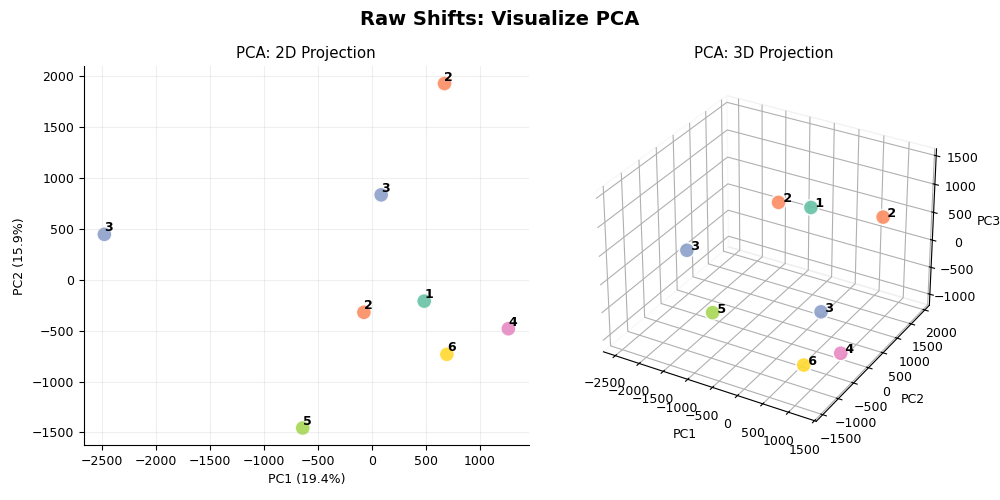

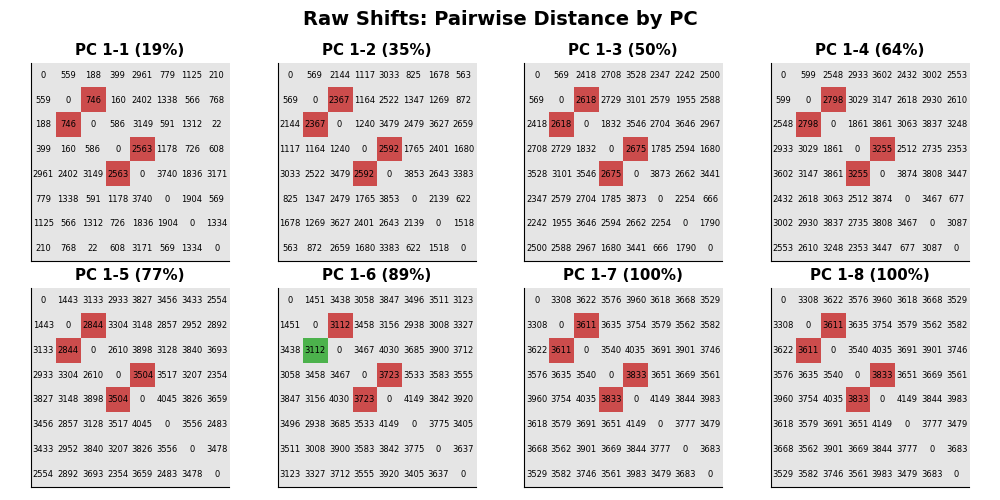

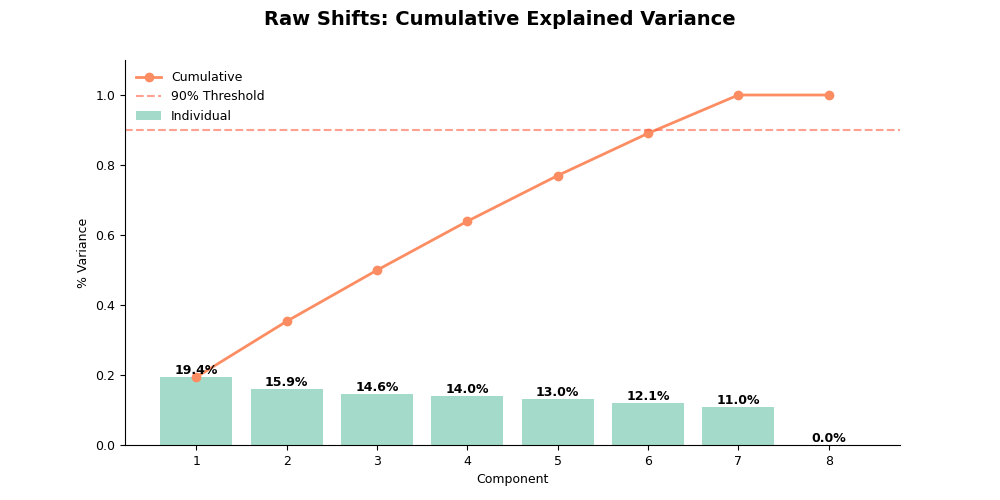

In [18]:
title_prefix = "Raw Shifts: "
_ = run_all_pca(data, 'raw_shifts', "Raw Shifts: ")

# 3. Compute FFT

In [19]:
MIN_FREQ, MAX_FREQ = 50, 2_000

In [20]:
def run_fft(shifts, fs, min_freq=None, max_freq=None):
    # compute fft values and frequencies
    fft_val = np.fft.rfft(shifts, axis=1)
    n_samples = shifts.shape[1]
    freq = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    if min_freq is not None and max_freq is not None:
        mask = (freq >= min_freq) & (freq <= max_freq)
        fft_val, freq = fft_val[:, mask, :], freq[mask]
    return fft_val, freq

In [21]:
for name, d in data.items():
    fft_val_raw, freq_raw = run_fft(d['raw_shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_val_raw'], d['freq_raw'] = fft_val_raw, freq_raw

In [22]:
fft_val_raw.shape

(100, 11701, 2)

In [23]:
freq_raw.shape

(11701,)

We have ~11k frequencies when we crop the frequncies to be between 50hz and 2_000 hz.

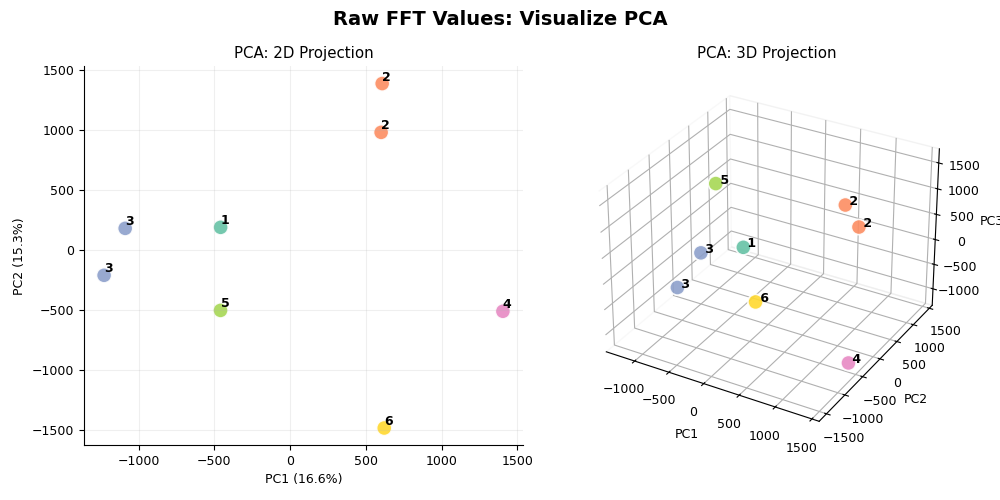

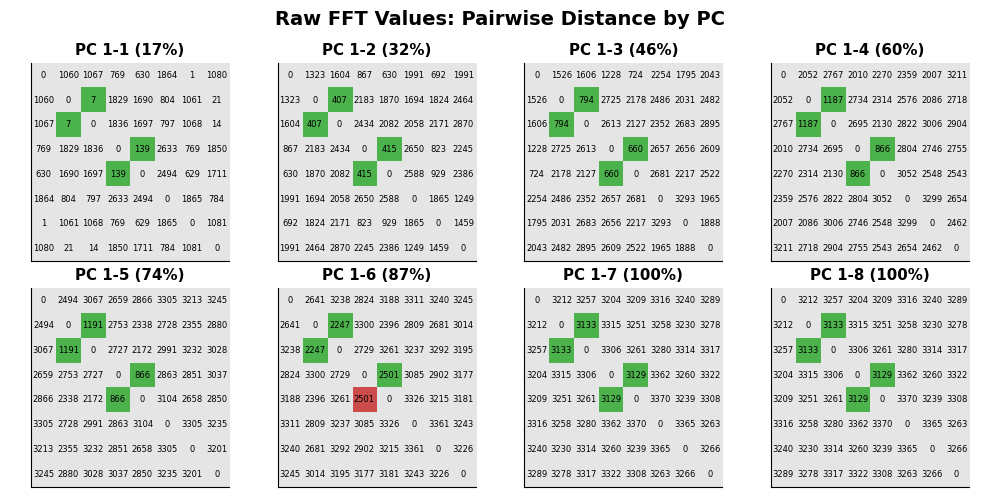

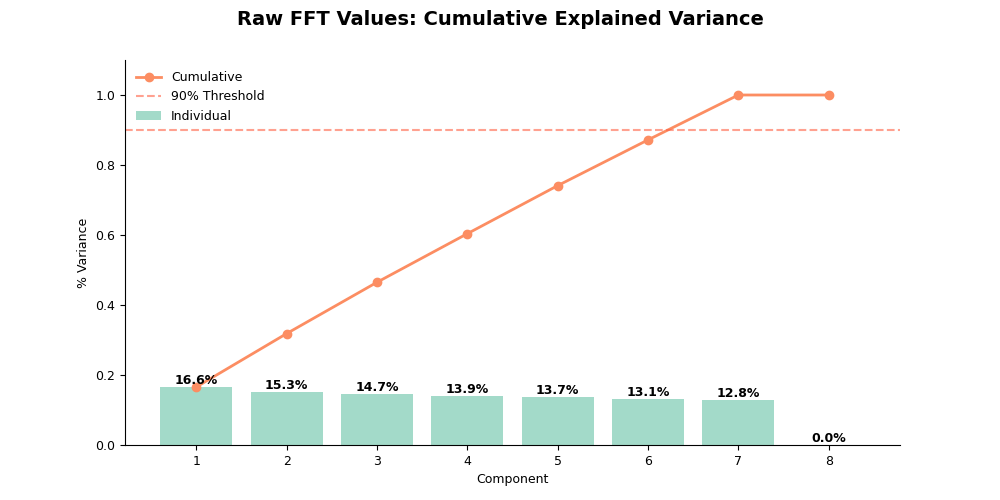

In [24]:
_ = run_all_pca(data, 'fft_val_raw', "Raw FFT Values: ")

# 4. Clean Data

In [25]:
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

In [26]:
def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, _, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [27]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

In [28]:
def fft_magnitude_mean(fft_vals):
    """Compute fft magnitude and average it over all the lasers and x,y coordinates"""
    assert len(fft_vals.shape) == 3
    return np.abs(fft_vals).mean(axis=(0,2)) # average over all lasers (dim 0), x/y coordinates (dim 2)

In [29]:
def plot_clean_data(shifts, fs):
    # fft for raw signal
    fft_vals, freqs = run_fft(shifts, fs)

    # fft for bandpass filter
    bp_shifts = bandpass_filter(shifts, fs)
    bp_fft_vals, bp_freqs = run_fft(bp_shifts, fs)

    # fft for bandpass filter + hann window
    wd_shifts = hann_window(bp_shifts)
    wd_fft_vals, wd_freqs = run_fft(wd_shifts, fs)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(freqs, fft_magnitude_mean(fft_vals), label='raw')
    ax.plot(bp_freqs, fft_magnitude_mean(bp_fft_vals), label='bandpass filter')
    ax.plot(wd_freqs, fft_magnitude_mean(wd_fft_vals), label='bandpass filter + hann window')
    ax.set(xlim=(45, 150), ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
    ax.legend()
    fig.suptitle('Clean the Data')
    return fig

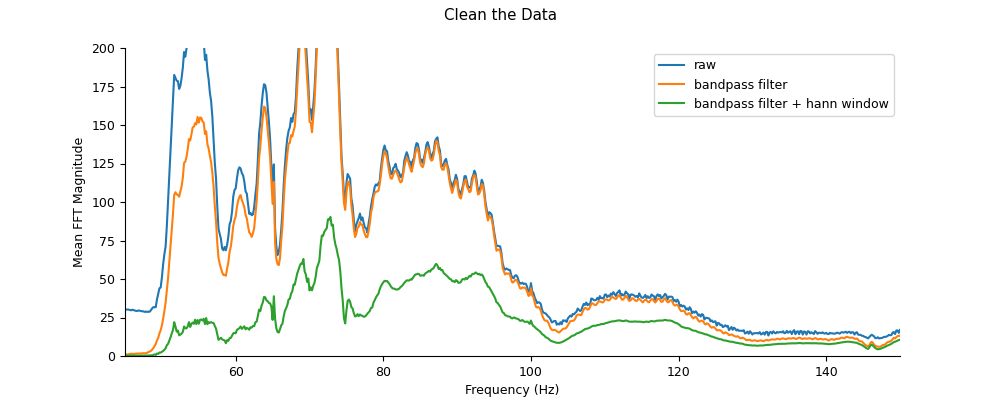

In [30]:
fig = plot_clean_data(raw_shifts, fs)

The fft vals looks much cleaner with bandpass filter + hann window. Let's define a function to clean the shifts and compute the fft on this cleaned data

In [31]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

In [32]:
for name, d in data.items():
    d['shifts'] = clean_shifts(d['raw_shifts'], d['fs'])
    fft_val, freq = run_fft(d['shifts'], d['fs'], MIN_FREQ, MAX_FREQ)
    d['fft_val'], d['freq'] = fft_val, freq

In [33]:
d.keys()

dict_keys(['object', 'position', 'duplicate_idx', 'fs', 'path', 'raw_shifts', 'timesteps', 'fft_val_raw', 'freq_raw', 'shifts', 'fft_val', 'freq'])

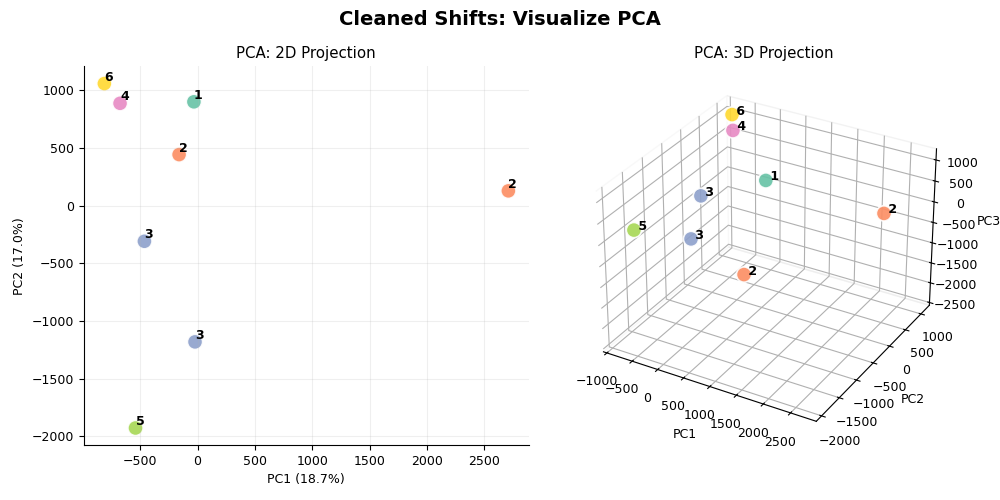

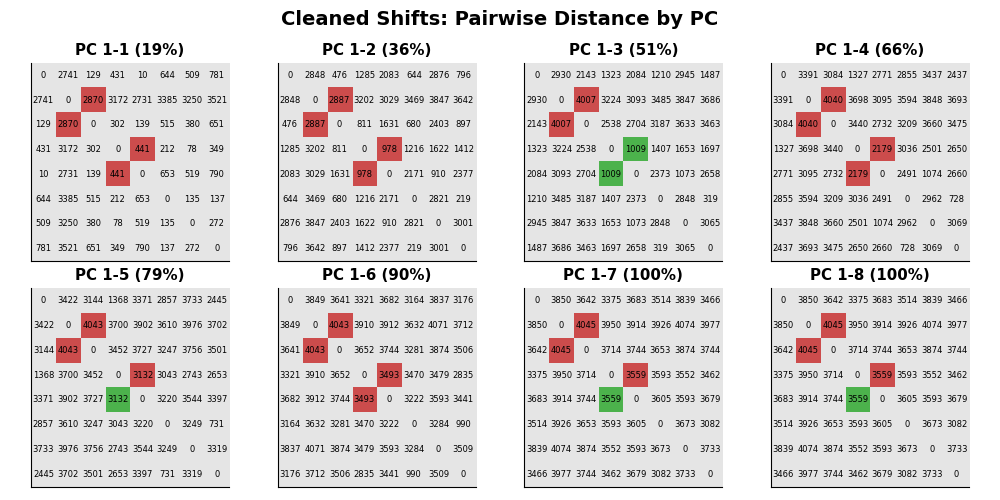

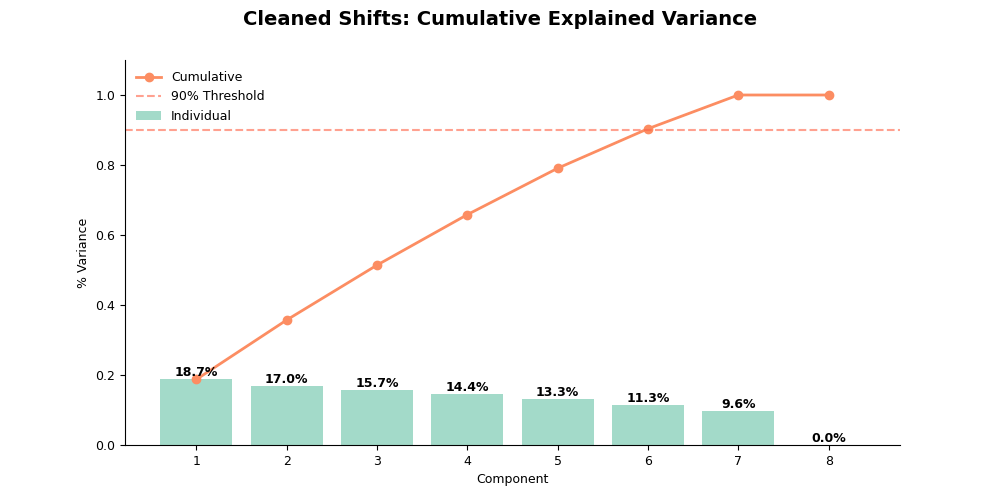

In [34]:
_ = run_all_pca(data, 'shifts', "Cleaned Shifts: ")

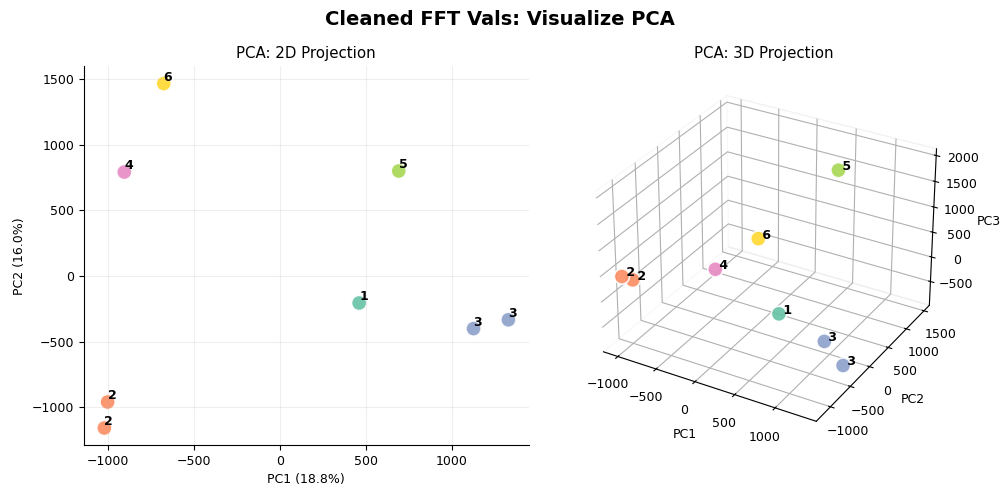

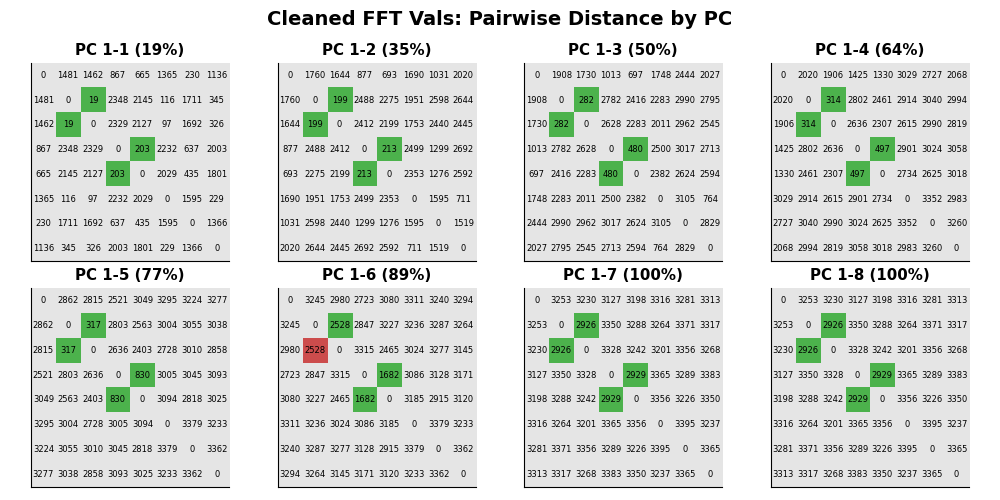

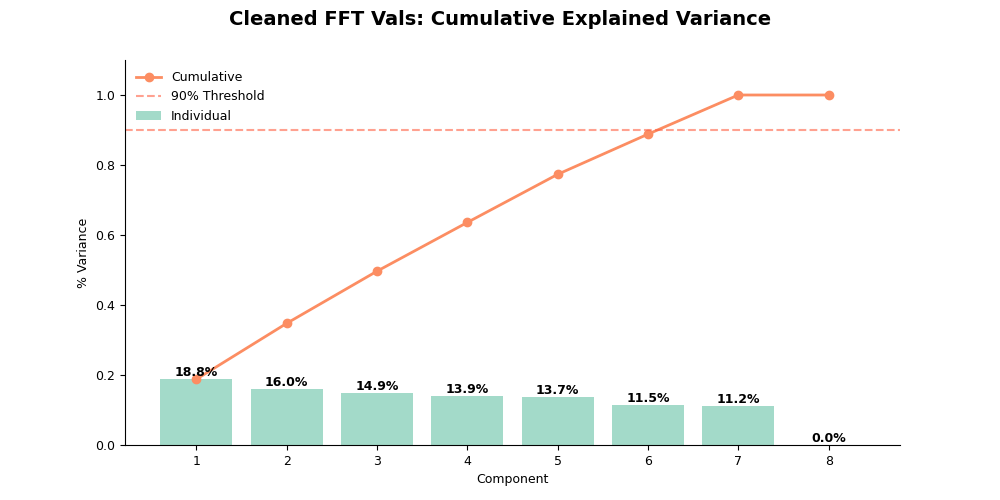

In [35]:
_ = run_all_pca(data, 'fft_val', "Cleaned FFT Vals: ")

# 5. Sync Phases

In [36]:
d['shifts'].shape

(100, 30000, 2)

Currently our shift data is "out of sync". Specifically, different lasers may have different phases, making it hard to compare one laser to another. Moreover, different experiments each with different box-positions might have global phase from timing jitter, reference clock drift, and other hardware side effects. We want to normalize the phase so that every laser is aligned, removing global phase. This mak

This makes it difficult to compare signals across different box-positions and given the same box-position, across different laser positions.


Let's sync the frequencies. This means that for each frequency, we will normalize all lasers and x/y coordinates. This allows us to compare lasers to each other.

Laser `laser_idx`, coordinate `xy_idx` has zero phase. All other lasers’ FFTs are expressed relative to that reference. This is helpful because
1. removes unobservable global phase from timing jitter, reference clock drift, 
2. with global phase removed, phase differences across the 10×10 laser grid become meaningful. you can now see wave propagation, standing modes
3. This makes PCA more meanignful


In [37]:
def sync_phases(fft_vals, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals_synced = fft_vals.copy()             # copy
    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref) + eps)    # unit complex
    fft_vals_synced *= phase[None, :, None]       # broadcast over lasers and xy
    return fft_vals_synced

In [38]:
for name, d in data.items():
    d['fft_val_synced'] = sync_phases(d['fft_val'])

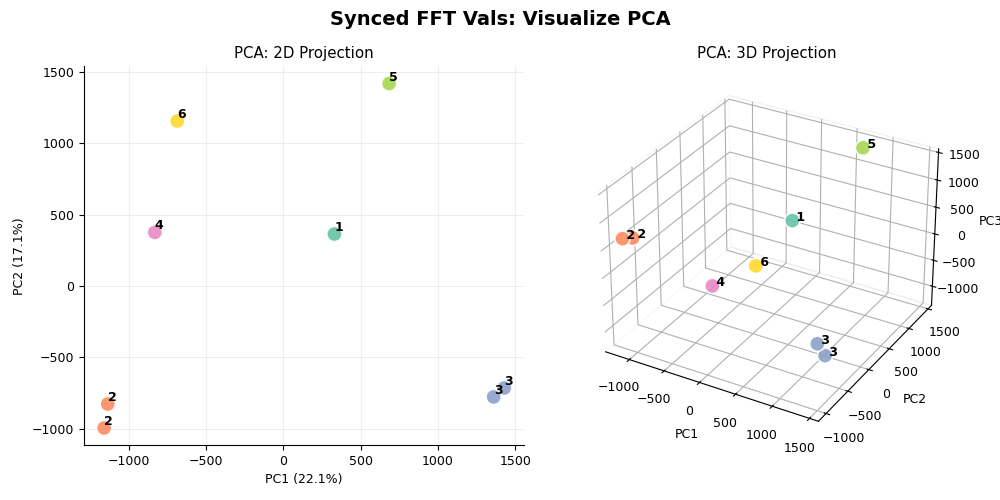

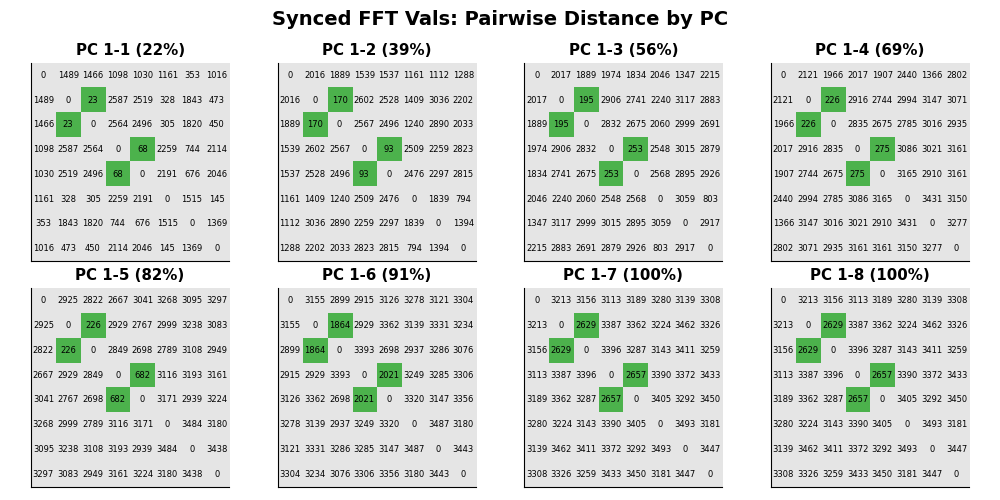

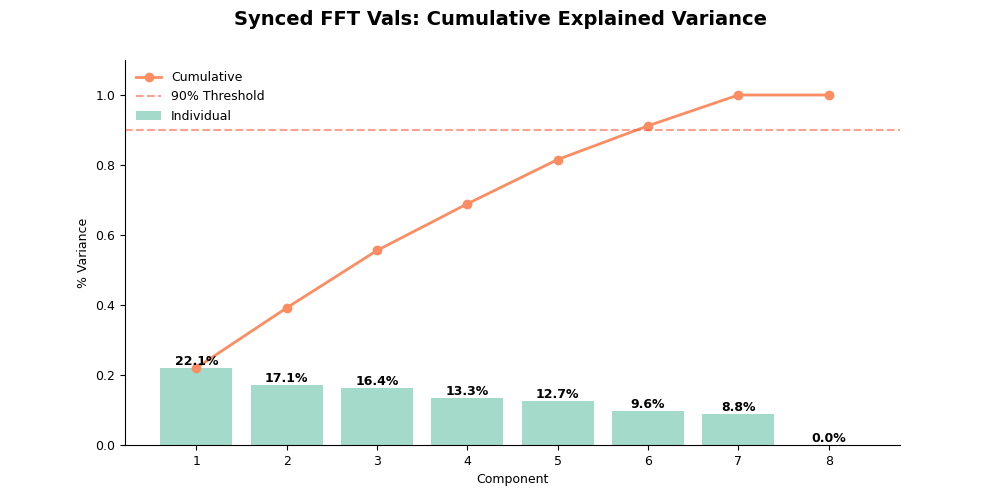

In [39]:
_ = run_all_pca(data, 'fft_val_synced', "Synced FFT Vals: ")

# 6. Compute Mode

In [40]:
from scipy.signal import find_peaks

In [46]:
def find_modes(freq, fft_val, n_modes=50, min_distance=10):
    """Find the top n_modes frequency peaks from mean FFT magnitude (averaged over lasers + x/y coordinate).

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """

    mean_mag = fft_magnitude_mean(fft_val)
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    top_peaks = peaks[top_indices]

    mode_freq = [freq[p] for p in sorted(top_peaks)]
    mode_fft_val = [fft_val[:, p, :] for p in sorted(top_peaks)]
    return mode_freq, mode_fft_val

In [47]:
for name, d in data.items():
    mode_freq, mode_fft_val = find_modes(d['freq'], d['fft_val'])
    d['mode_freq'], d['mode_fft_val'] = mode_freq, mode_fft_val

    mode_freq_synced, mode_fft_val_synced = find_modes(d['freq'], d['fft_val_synced'])
    d['mode_freq_synced'], d['mode_fft_val_synced'] = mode_freq_synced, mode_fft_val_synced

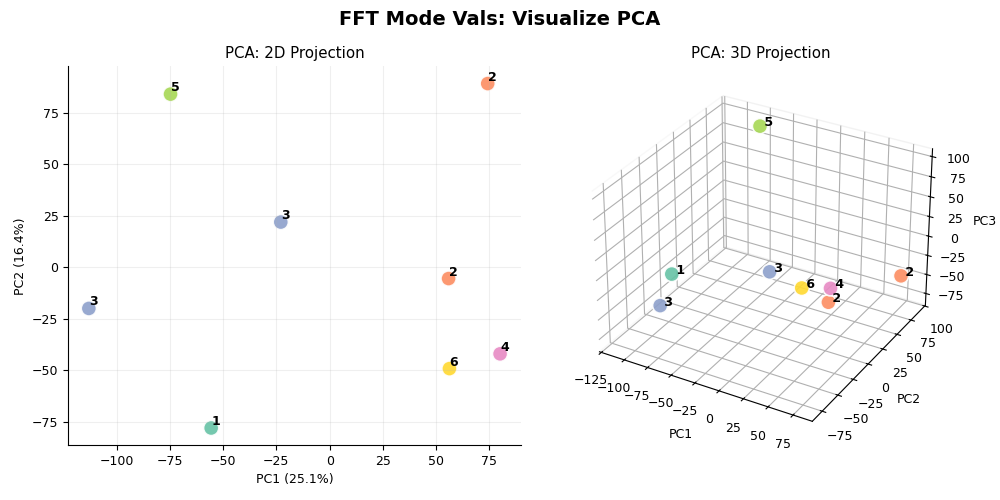

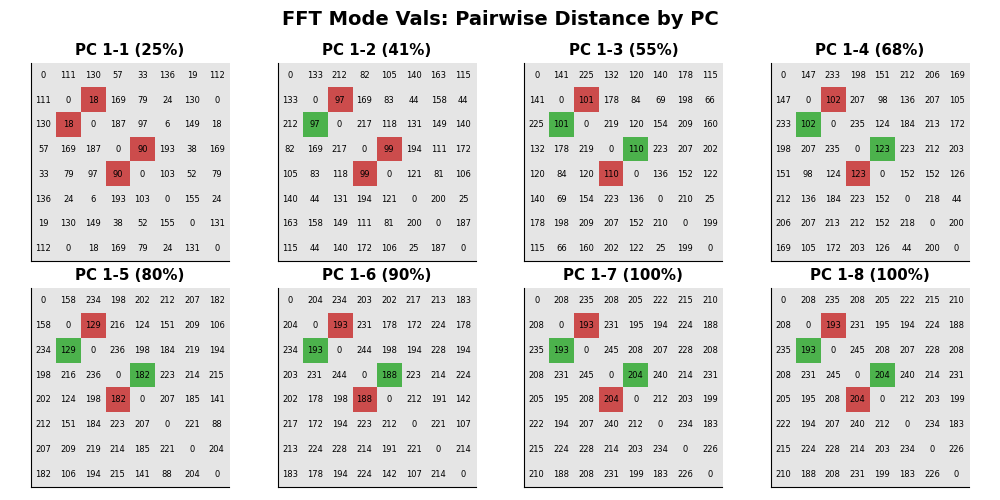

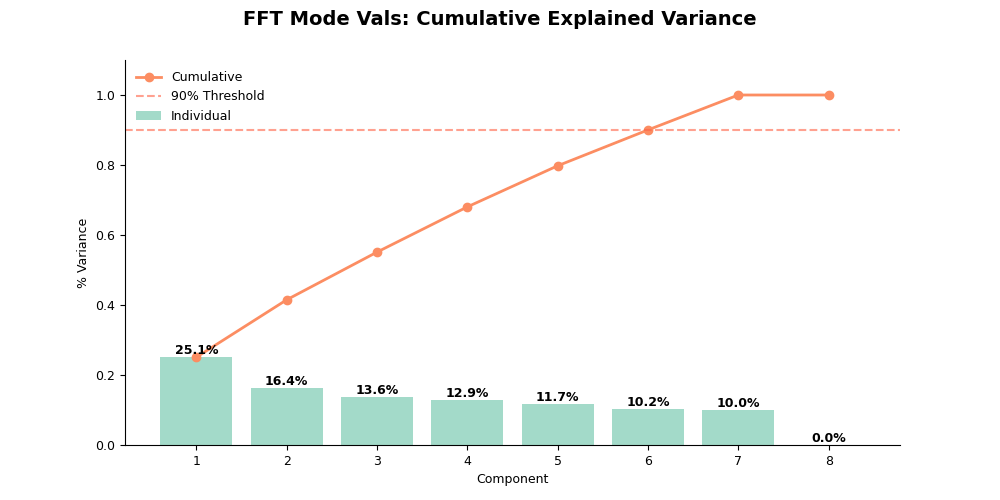

In [48]:
_ = run_all_pca(data, 'mode_fft_val', "FFT Mode Vals: ")

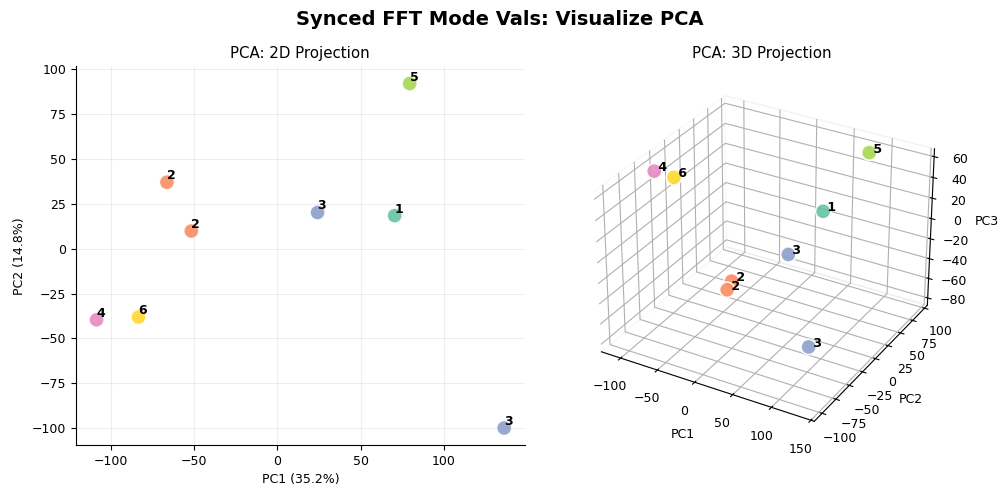

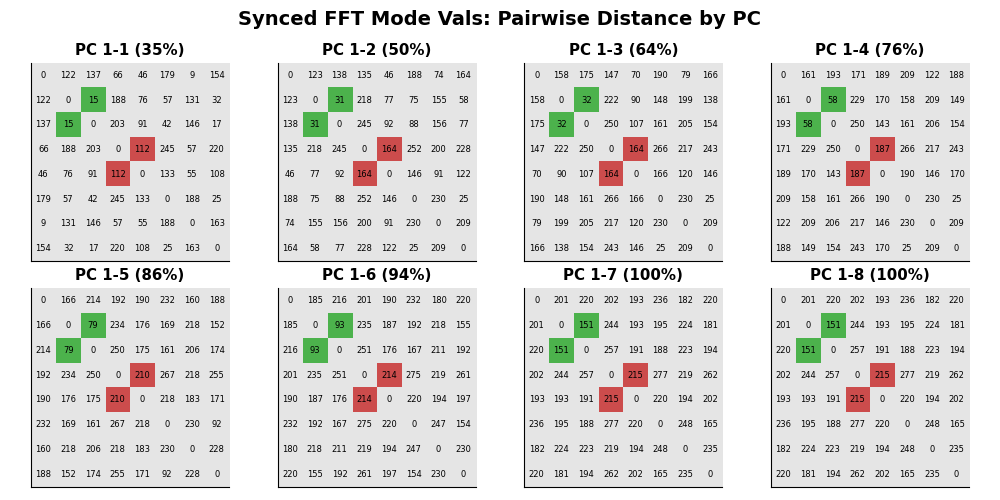

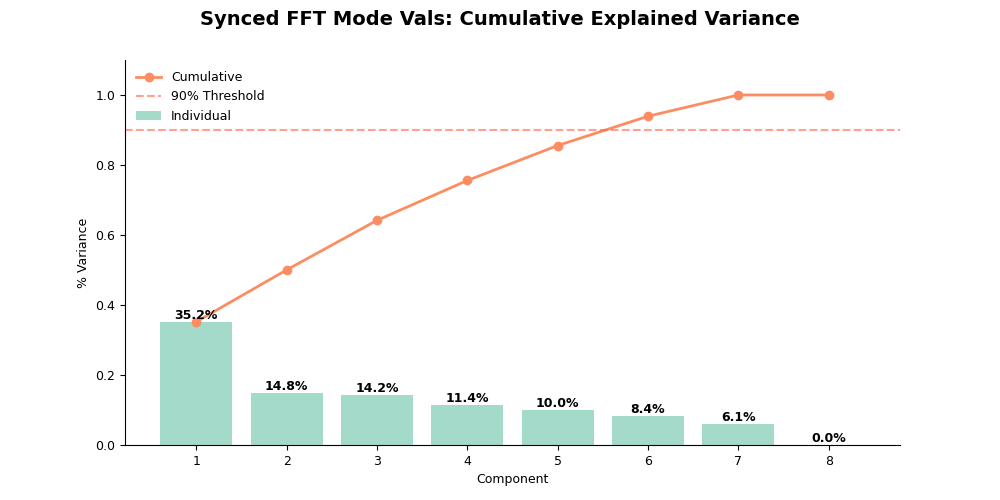

In [49]:
_ = run_all_pca(data, 'mode_fft_val_synced', "Synced FFT Mode Vals: ")